In [4]:
import torch
c2w = torch.randn((100,12,1))
c2w = c2w[None, :3, -1]
print(c2w.shape)

torch.Size([256, 512])     torch.Size([256, 512])


tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
        [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
        ...,
        [253., 253., 253.,  ..., 253., 253., 253.],
        [254., 254., 254.,  ..., 254., 254., 254.],
        [255., 255., 255.,  ..., 255., 255., 255.]])

In [ ]:
import torch
from einops import rearrange

x = torch.rand(16,1,6)
print(x)

print(torch.mean(x))


In [ ]:
import torch
img1 = torch.ones(16,1,3,512,512)
img0 = torch.zeros(16,1,3,512,512)
imgs = torch.cat([img0,img1],dim=1)

two_imgs_forward = torch.cat((imgs[:, :-1], imgs[:, 1:]), dim=2)
two_imgs_backward = torch.cat((imgs[:, 1:], imgs[:, :-1]), dim=2)
print(two_imgs_forward.shape)
print(two_imgs_backward)

In [67]:
import matplotlib.pyplot as plt
import numpy as np
pose_abs, pose_rel = read_pose_from_text("/data/lijingfeng/pro/Visual-Selective-VIO/data/poses/05.txt")
pose_abs = np.array(pose_abs)
pose_rel = np.array(pose_rel)
x = pose_abs[:,0,3]
y = pose_abs[:,1,3]
z = pose_abs[:,2,3]

#画图
style_gt = 'r-'
style_O = 'ko'
plot_keys = ["Ground Truth", "Ours"]
plt.plot(x, y, style_gt, label=plot_keys[0])
start_point = [0, 0]
ax = plt.gca()
plt.plot(start_point[0], start_point[1], style_O, label='Start Point')
plt.legend(loc="upper right", prop={'size': 10})
plt.xlabel('x (m)', fontsize=10)
plt.ylabel('y (m)', fontsize=10)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xmean = np.mean(xlim)
ymean = np.mean(ylim)
plot_radius = max([abs(lim - mean_)
                   for lims, mean_ in ((xlim, xmean),
                                       (ylim, ymean))
                   for lim in lims])
ax.set_xlim([xmean - plot_radius, xmean + plot_radius])
ax.set_ylim([ymean - plot_radius, ymean + plot_radius])
plt.title('2D path')
plt.savefig("/data/lijingfeng/pro/Visual-Selective-VIO/seq05gt.png", bbox_inches='tight', pad_inches=0.1)


FileNotFoundError: [Errno 2] No such file or directory: '/data/lijingfeng/pro/Visual-Selective-VIO/data/poses/05.txt'

In [3]:
from functools import partial
from pointnav_vo.mmae import *
DOMAIN_CONF = {
                'rgb': {
                    'input_adapter': partial(PatchedInputAdapter, num_channels=3, stride_level=1),
                    'output_adapter': partial(PatchedOutputAdapterXA, num_channels=3, stride_level=1),
                    'loss': MaskedMSELoss,
                },
                'depth': {
                    'input_adapter': partial(PatchedInputAdapter, num_channels=1, stride_level=1),
                    'output_adapter': partial(PatchedOutputAdapterXA, num_channels=1, stride_level=1),
                    'loss': MaskedMSELoss,
                },
                'semseg': {
                    'input_adapter': partial(SemSegInputAdapter, num_classes=133,
                                            dim_class_emb=64, interpolate_class_emb=False, stride_level=4),
                    'output_adapter': partial(PatchedOutputAdapterXA, num_channels=133, stride_level=4),
                    'loss': MaskedCrossEntropyLoss,
                },
            }
input_adapters = {
    domain: dinfo['input_adapter'](
        patch_size_full = 16,
    )
    for domain, dinfo in DOMAIN_CONF.items()
    if domain in ['rgb','depth']
}
print(input_adapters)

{'rgb': PatchedInputAdapter(), 'depth': PatchedInputAdapter()}


In [ ]:
import torch
import torch.nn as nn

model = nn.LayerNorm(1,2,3)
input = torch.randn(2,3).to('cuda:0')
model.cuda(1)

out = model(input)
# prove model and input tensor must be the same device

In [ ]:
# 模型一般随机初始化，现在将其参数初始化为全0
# 将模型参数初始化为0
from vo_transformer import VisualOdometryTransformerActEmbed
model = VisualOdometryTransformerActEmbed(obs_size_single=(192,341),cls_action=False)

for param in model.parameters():
    param.data.fill_(0)

In [ ]:
import torch
import torch.nn as nn
from vo_transformer import VisualOdometryTransformerActEmbed

model = VisualOdometryTransformerActEmbed(obs_size_single=(192,341),cls_action=False)
# 权重参数的keys
model_state = torch.load('./model_zoo/fix_model.pth')
print(model_state[-1].keys())
# 模型的keys
print(model.state_dict().keys())

In [ ]:
# 将cvpr的模型加载到这个框架下，先是将所估计的seq5的结果保存到txt文件中（x,z,yaw）
import torch
import torch.nn as nn
from vo_transformer import VisualOdometryTransformerActEmbed

model = VisualOdometryTransformerActEmbed(cls_action=False)
model.load_state_dict(torch.load('./model_zoo/remove_module_fix_model.pth'))

# 保存直接使用test.py中的代码，修改eval中的部分代码

In [65]:
# SVIO中的pose转换代码
import numpy as np
import math
_EPS = np.finfo(float).eps * 4.0

def read_pose(line):
    '''
    Reading 4x4 pose matrix from .txt files
    input: a line of 12 parameters
    output: 4x4 numpy matrix
    '''
    values= np.reshape(np.array([float(value) for value in line.split(' ')]), (3, 4))
    Rt = np.concatenate((values, np.array([[0, 0, 0, 1]])), 0)
    return Rt

def get_relative_pose(Rt1, Rt2):
    '''
    Calculate the relative 4x4 pose matrix between two pose matrices
    '''
    Rt1_inv = np.linalg.inv(Rt1)
    Rt_rel = Rt1_inv @ Rt2
    return Rt_rel

def euler_from_matrix(matrix):
    '''
    Extract the eular angle from a rotation matrix
    '''
    M = np.array(matrix, dtype=np.float64, copy=False)[:3, :3]
    cy = math.sqrt(M[0, 0] * M[0, 0] + M[1, 0] * M[1, 0])
    ay = math.atan2(-M[2, 0], cy)
    if ay < -math.pi / 2 + _EPS and ay > -math.pi / 2 - _EPS:  # pitch = -90 deg
        ax = 0
        az = math.atan2(-M[1, 2], -M[0, 2])
    elif ay < math.pi / 2 + _EPS and ay > math.pi / 2 - _EPS:
        ax = 0
        az = math.atan2(M[1, 2], M[0, 2])
    else:
        ax = math.atan2(M[2, 1], M[2, 2])
        az = math.atan2(M[1, 0], M[0, 0])
    return np.array([ax, ay, az])

def get_relative_pose_6DoF(Rt1, Rt2):
    '''
    Calculate the relative rotation and translation from two consecutive pose matrices 
    '''
    
    # Calculate the relative transformation Rt_rel
    Rt_rel = get_relative_pose(Rt1, Rt2)

    R_rel = Rt_rel[:3, :3]
    t_rel = Rt_rel[:3, 3]

    # Extract the Eular angle from the relative rotation matrix
    x, y, z = euler_from_matrix(R_rel)
    theta = [x, y, z]

    pose_rel = np.concatenate((t_rel, theta))
    return pose_rel

def read_pose_from_text(path):
    with open(path) as f:
        lines = [line.split('\n')[0] for line in f.readlines()]
        poses_rel, poses_abs = [], []
        values_p = read_pose(lines[0])
        poses_abs.append(values_p)            
        for i in range(1, len(lines)):
            values = read_pose(lines[i])
            poses_rel.append(get_relative_pose_6DoF(values_p, values)) 
            values_p = values.copy()
            poses_abs.append(values) 
        poses_abs = np.array(poses_abs)
        poses_rel = np.array(poses_rel)

    return poses_abs, poses_rel

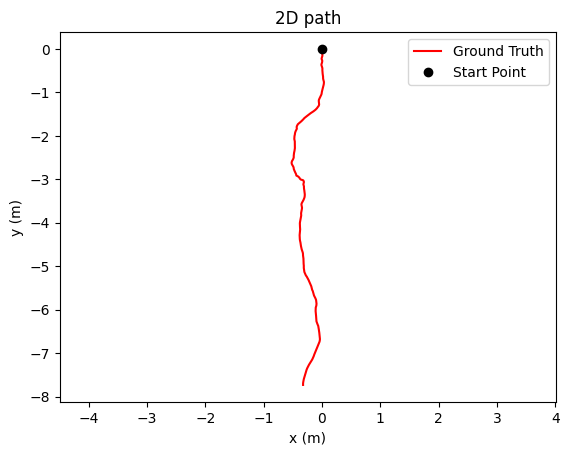

In [98]:
import matplotlib.pyplot as plt
import numpy as np

def plot(pose_gt, pose_est=None):
    x_gt = pose_gt[:,0,3]
    y_gt = pose_gt[:,1,3]
    z_gt = pose_gt[:,2,3]

    #画图
    style_gt = 'r-'
    style_est = 'b-'
    style_O = 'ko'

    plot_keys = ["Ground Truth", "Ours"]
    plt.plot(x_gt, y_gt, style_gt, label=plot_keys[0])
    if pose_est is not None:
        x_est = pose_est[:,0]
        y_est = pose_est[:,1]
        plt.plot(x_est, y_est, style_est, label=plot_keys[1])
    start_point = [0, 0]
    ax = plt.gca()
    plt.plot(start_point[0], start_point[1], style_O, label='Start Point')
    plt.legend(loc="upper right", prop={'size': 10})
    plt.xlabel('x (m)', fontsize=10)
    plt.ylabel('y (m)', fontsize=10)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xmean = np.mean(xlim)
    ymean = np.mean(ylim)
    plot_radius = max([abs(lim - mean_)
                    for lims, mean_ in ((xlim, xmean),
                                        (ylim, ymean))
                    for lim in lims])
    ax.set_xlim([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim([ymean - plot_radius, ymean + plot_radius])
    plt.title('2D path')
    plt.savefig("./fig/seq04gt_xy.png", bbox_inches='tight', pad_inches=0.1)

pose_abs, pose_rel = read_pose_from_text("./data/poses/01.txt")
# poses_est_mat = np.loadtxt("cvpr_seq04_global_pose_3dof_xy.txt")
poses_est_mat = None
pose_abs = np.array(pose_abs)
pose_rel = np.array(pose_rel)
plot(pose_abs, poses_est_mat)


In [ ]:
import torch
import torch.nn.functional as F

# 生成模型的预测值和真实目标值
input = torch.tensor([1.0, 2.0, 3.0])
target = torch.tensor([2.0, 2.5, 3.5])

# 计算均方误差损失
loss = F.mse_loss(input, target)

print(loss.item())  # 打印损失值


In [104]:
# 读取kitti中seq5的数据，只要x,y,yaw数据，保存为gt
import numpy as np

file_path = "./data/poses/04.txt"
file_save_path = "gt_seq4_rel_pose_3dof.txt"

poses_abs, poses_rel = read_pose_from_text(file_path)
np.savetxt(file_save_path, np.array(poses_rel)[:,[0,1,5]])

In [4]:
import torch
import torch.nn as nn

x = torch.randn((2,1,11,6)).cuda(1)
batch_size = x.shape[0]
seq_len = x.shape[1]
x = x.view(batch_size * seq_len, x.size(2), x.size(3))    # x: (N x seq_len, 11, 6)
conv = nn.Conv1d(6, 64, kernel_size=3, padding=1)
conv.cuda(1)
result = conv(x.permute(0, 2, 1))
print(result.shape)

torch.Size([2, 64, 11])


: 

In [105]:
# 然后将这个txt文件读取出来，然后将其转换为pose_abs和pose_rel 2维坐标系下
import numpy as np
import math

def pose_3DoF_to_matrix(pose):
    '''
    Calculate the 3x3 transformation matrix from Eular angles and translation vector
    '''
    delta_yaw_rad = pose[2]
    R = np.array([[math.cos(delta_yaw_rad), -math.sin(delta_yaw_rad)],
                  [math.sin(delta_yaw_rad), math.cos(delta_yaw_rad)]])
    t = T = np.array([[pose[0]],
                  [pose[1]]])
    R = np.concatenate((R, t), 1)
    R = np.concatenate((R, np.array([[0, 0, 1]])), 0)

    return R

def pose_accu(Rt_pre, R_rel):
    '''
    Calculate the accumulated pose from the latest pose and the relative rotation and translation
    '''
    Rt_rel = pose_3DoF_to_matrix(R_rel)
    return Rt_pre @ Rt_rel

def path_accu(pose):
    '''
    Generate the global pose matrices from a series of relative poses
    '''
    answer = [np.eye(3)]
    for index in range(pose.shape[0]):
        pose_ = pose_accu(answer[-1], pose[index, :])
        answer.append(pose_)
    return answer

relative_poses = np.loadtxt('gt_seq4_rel_pose_3dof.txt')  # 假设poses.txt包含x,z,yaw的相对姿态数据
# relative_poses = np.loadtxt('cvpr_seq04_rel_pose_3dof_xypitchz.txt')  # 假设poses.txt包含x,z,yaw的相对姿态数据

global_poses = path_accu(relative_poses)
pose_3dof = np.array(global_poses).reshape(-1,1,9)

np.savetxt("gt_seq4_global_pose_3dof.txt", pose_3dof.squeeze(1)[:,[2,5]])
# np.savetxt("cvpr_seq4_global_pose_3dof.txt", pose_3dof.squeeze(1)[:,[2,5]])


In [ ]:
# chatgpt给出的示例，不对
def relative_to_global_pose(x_rel, z_rel, yaw_rel, x_ref, z_ref, yaw_ref):
    # delta_yaw_rad = math.radians(yaw_rel)
    # 本来就是弧度
    delta_yaw_rad = yaw_rel
    R = np.array([[math.cos(delta_yaw_rad), -math.sin(delta_yaw_rad)],
                  [math.sin(delta_yaw_rad), math.cos(delta_yaw_rad)]])
    T = np.array([[x_rel],
                  [z_rel]])
    global_pose = np.dot(R, np.array([[x_ref], [z_ref]])) + T

    return x_global, z_global, yaw_global

# 从文本文件中读取相对姿态数据
relative_poses = np.loadtxt('gt_seq5_rel_pose_3dof.txt')  # 假设poses.txt包含x,z,yaw的相对姿态数据
# relative_poses = np.loadtxt('cvpr_seq5_rel_pose_3dof.txt')  # 假设poses.txt包含x,z,yaw的相对姿态数据

# 假设参考全局姿态为 (x_ref, z_ref, yaw_ref)
x_ref = 0
z_ref = 0
yaw_ref = 0
print("坐标系原点：", x_ref,'  ',z_ref,'  ', yaw_ref, "rad")

# 转换相对姿态为全局姿态
global_poses = []
for relative_pose in relative_poses:
    x_rel, z_rel, yaw_rel = relative_pose
    x_global, z_global, yaw_global = relative_to_global_pose(x_rel, z_rel, yaw_rel, x_ref, z_ref, yaw_ref)
    global_poses.append([x_global, z_global, yaw_global])
    x_ref = x_global
    z_ref = z_global
    yaw_ref = yaw_global

# 打印全局姿态数据
for global_pose in global_poses:
    # print(global_pose)
    # np.savetxt("cvpr_seq5_global_pose_3dof.txt", np.array(global_poses))
    np.savetxt("gt_seq5_global_pose_3dof.txt", np.array(global_poses))

In [107]:
# plot 2D path图，只需要用到x,z坐标
import matplotlib.pyplot as plt

def plotPath_2D(seq, poses_gt_mat, poses_est_mat, plot_path_dir):

    fontsize_ = 10
    plot_keys = ["Ground Truth", "Ours"]
    start_point = [0, 0]
    style_pred = 'b-'
    style_gt = 'r-'
    style_O = 'ko'

    # get the value
    x_gt = [pose[0] for pose in poses_gt_mat]
    z_gt = [pose[1] for pose in poses_gt_mat]

    x_pred = [pose[0] for pose in poses_est_mat]
    z_pred = [pose[1] for pose in poses_est_mat]

    # Plot 2d trajectory estimation map
    fig = plt.figure(figsize=(6, 6), dpi=100)
    ax = plt.gca()
    plt.plot(x_gt, z_gt, style_gt, label=plot_keys[0]) 
    # plt.plot(x_pred, z_pred, style_pred, label=plot_keys[1])
    plt.plot(start_point[0], start_point[1], style_O, label='Start Point')
    plt.legend(loc="upper right", prop={'size': fontsize_})
    plt.xlabel('x (m)', fontsize=fontsize_)
    plt.ylabel('z (m)', fontsize=fontsize_)
    # set the range of x and y
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xmean = np.mean(xlim)
    ymean = np.mean(ylim)
    plot_radius = max([abs(lim - mean_)
                       for lims, mean_ in ((xlim, xmean),
                                           (ylim, ymean))
                       for lim in lims])
    ax.set_xlim([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim([ymean - plot_radius, ymean + plot_radius])

    plt.title('2D path')
    png_title = "{}_path_2d".format(seq)
    plt.savefig(plot_path_dir + "/" + png_title + ".png", bbox_inches='tight', pad_inches=0.1)
    plt.close()

In [108]:
# 使用plotPath_2D
import numpy as np
seq = '04'
poses_gt_mat = np.loadtxt("gt_seq4_global_pose_3dof.txt")
poses_est_mat = np.loadtxt("cvpr_seq4_global_pose_3dof.txt")
plot_path_dir = "./fig"

plotPath_2D(seq, poses_gt_mat, poses_est_mat, plot_path_dir)

In [32]:
# 计算rel pose的误差
def rmse_err_cal(pose_est, pose_gt):
    '''
    Calculate the rmse of relative translation and rotation
    '''
    t_rmse = np.sqrt(np.mean(np.sum((pose_est[:, :2] - pose_gt[:, :2])**2, -1)))
    r_rmse = np.sqrt(np.mean(np.sum((pose_est[:, 2] - pose_gt[:, 2])**2, -1)))
    return t_rmse, r_rmse

In [44]:
pose_est = np.loadtxt("cvpr_seq4_rel_pose_3dof.txt")
pose_gt = np.loadtxt("gt_seq4_rel_pose_3dof.txt")
t_rmse, r_rmse = rmse_err_cal(pose_est, pose_gt)
print("t_rmse: ", t_rmse, "r_rmse: ", r_rmse)

t_rmse:  6.636896475837878 r_rmse:  81.98909829795181


In [ ]:
pose_est = pose_est[:,[3,5,1]]
print(pose_est)
t_rmse, r_rmse = rmse_err_cal(pose_est, pose_gt)
print("t_rmse: ", t_rmse, "r_rmse: ", r_rmse)